# Neural SDE: Learning Market Dynamics from Real Data (실제 데이터 기반 시장 역학 학습)

## Goal (목표)
We learn the Drift and Diffusion functions of an SDE directly from **real S&P 500 data**, instead of assuming a mathematical formula like the Heston Model.
Heston Model과 같은 수학적 가정을 버리고, **실제 S&P 500 데이터**로부터 SDE의 Drift/Diffusion 함수를 직접 학습합니다.

## Why Neural SDE? (왜 Neural SDE인가?)
- **GAN**: Generates realistic data but lacks explicit probability density (PDF), making Girsanov Theorem inapplicable.
- **Neural SDE**: Maintains SDE flexibility while learning functions via Neural Networks. **Compatible with Girsanov Theorem**, enabling Neural Path Integral (NPI).
- **GAN**: 그럴듯한 데이터를 생성하지만 확률 밀도(PDF)를 알 수 없어 Girsanov 정리를 적용할 수 없습니다.
- **Neural SDE**: SDE 구조를 유지하며 신경망으로 함수를 학습합니다. **Girsanov 정리와 호환**되므로 NPI 프레임워크에 적용 가능합니다.

In [1]:
# =============================================================================
# Environment Setup (환경 설정)
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Preparation (데이터 준비)

Load S&P 500 (SPY ETF) daily returns prepared in `01_Data_Loader.ipynb`.
`01_Data_Loader.ipynb`에서 준비된 S&P 500 (SPY ETF) 일별 수익률 데이터를 로드합니다.

In [2]:
# =============================================================================
# Load Data (데이터 로드)
# =============================================================================

data_path = '../data/processed/spy_returns.csv'

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
else:
    print("⚠️ Data not found! Please run '01_Data_Loader.ipynb' first.")
    # Fallback to synthetic data if file missing (파일 없을 시 합성 데이터 사용)
    print("Using synthetic data for demonstration...")
    np.random.seed(42)
    n_days = 3500
    returns = np.random.normal(0.0003, 0.012, n_days)
    crash_days = np.random.choice(n_days, size=50, replace=False)
    returns[crash_days] = np.random.normal(-0.03, 0.02, 50)
    df = pd.DataFrame({'Returns': returns})

print(f"Data shape: {df.shape}")
print(df.describe())

Loading data from ../data/processed/spy_returns.csv...
Data shape: (5283, 2)
             Close      Returns
count  5283.000000  5283.000000
mean    225.677229     0.000402
std     156.832879     0.012011
min      49.944595    -0.115887
25%      98.506023    -0.003952
50%     171.684845     0.000717
75%     315.199982     0.005785
max     690.380005     0.135577


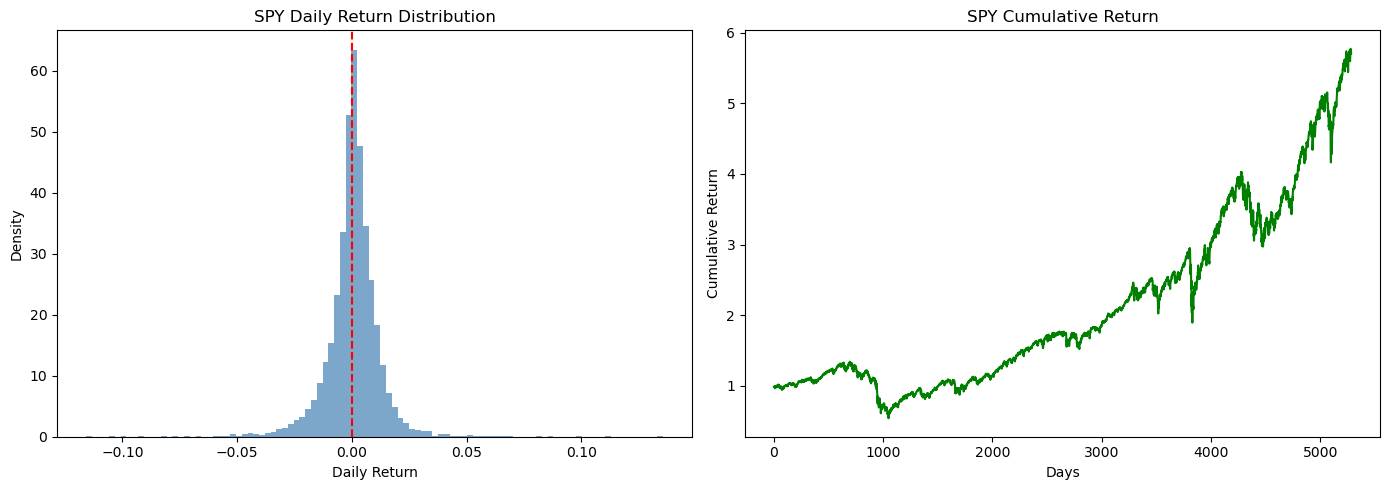


Statistics:
  Mean daily return (일평균 수익률): 0.0402%
  Std (Volatility) (표준편차/변동성):  1.2010%
  Annualized Vol (연환산 변동성):      19.06%
  Skewness (왜도):                     -0.3050
  Kurtosis (첨도):                     14.7128


In [18]:
# =============================================================================
# Visualize Return Distribution (수익률 분포 시각화)
# =============================================================================

returns = df['Returns'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(returns, bins=100, color='steelblue', alpha=0.7, density=True)
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title('SPY Daily Return Distribution')
axes[0].axvline(x=0, color='red', linestyle='--')

cumulative = (1 + df['Returns']).cumprod()
axes[1].plot(cumulative.values, color='green')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('SPY Cumulative Return')

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean daily return (일평균 수익률): {returns.mean()*100:.4f}%")
print(f"  Std (Volatility) (표준편차/변동성):  {returns.std()*100:.4f}%")
print(f"  Annualized Vol (연환산 변동성):      {returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Skewness (왜도):                     {pd.Series(returns).skew():.4f}")
print(f"  Kurtosis (첨도):                     {pd.Series(returns).kurtosis():.4f}")

## 2. Define Neural SDE Model (Neural SDE 모델 정의)

**SDE Structure (SDE 구조):**
$$dS_t = \mu_{\theta}(S_t, t) \cdot S_t \cdot dt + \sigma_{\phi}(S_t, t) \cdot S_t \cdot dW_t$$

- $\mu_{\theta}$: Neural Network (Learns Drift / Drift 함수 학습)
- $\sigma_{\phi}$: Neural Network (Learns Diffusion with Softplus / Diffusion 함수 학습)

In [4]:
# =============================================================================
# Define Neural SDE Classes (Neural SDE 클래스 정의)
# =============================================================================

class NeuralDrift(nn.Module):
    """
    Neural network that learns the drift function.
    Drift 함수를 학습하는 신경망입니다.
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        x = torch.stack([log_S, t], dim=-1)
        return self.net(x).squeeze(-1)


class NeuralDiffusion(nn.Module):
    """
    Neural network that learns the diffusion function.
    Diffusion 함수를 학습하는 신경망입니다.
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        x = torch.stack([log_S, t], dim=-1)
        raw = self.net(x).squeeze(-1)
        return F.softplus(raw) + 0.01


class ControlNet(nn.Module):
    """
    Neural network that learns the control function for NPI.
    NPI를 위한 제어(Control) 함수를 학습하는 신경망입니다.
    Used to modify drift to generate rare events (crashes).
    """
    def __init__(self, hidden_dim=64, control_bound=3.0):
        super().__init__()
        self.control_bound = control_bound
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        """
        Args:
            log_S: Log price / 로그 주가 (batch,)
            t: Time / 시간 (batch,)
        Returns:
            u: Control force / 제어력 (batch,) - bounded by tanh
        """
        x = torch.stack([log_S, t], dim=-1)
        raw = self.net(x).squeeze(-1)
        return self.control_bound * torch.tanh(raw)


class NeuralSDEModel(nn.Module):
    """
    Complete Neural SDE model with optional control.
    제어(Control) 기능이 통합된 Neural SDE 전체 모델입니다.
    """
    def __init__(self, hidden_dim=64, device='cuda'):
        super().__init__()
        self.drift_net = NeuralDrift(hidden_dim).to(device)
        self.diff_net = NeuralDiffusion(hidden_dim).to(device)
        self.device = device
    
    def simulate(self, S0, T, dt, num_paths):
        """
        Simulate paths using Neural SDE without control.
        제어(Control) 없이 Neural SDE로 경로를 시뮬레이션합니다.
        """
        n_steps = int(T / dt)
        log_S = torch.log(torch.full((num_paths,), S0, device=self.device))
        log_S_paths = [log_S.clone()]
        
        for step in range(n_steps):
            t = step * dt
            t_tensor = torch.full((num_paths,), t, device=self.device)
            
            mu = self.drift_net(log_S, t_tensor)
            sigma = self.diff_net(log_S, t_tensor)
            dW = torch.randn(num_paths, device=self.device) * np.sqrt(dt)
            
            log_S = log_S + (mu - 0.5 * sigma**2) * dt + sigma * dW
            log_S_paths.append(log_S.clone())
        
        log_S_paths = torch.stack(log_S_paths, dim=1)
        S_paths = torch.exp(log_S_paths)
        return S_paths
    
    def simulate_controlled(self, S0, T, dt, num_paths, control_net):
        """
        Simulate paths using Neural SDE with control (for NPI).
        제어된(Controlled) Neural SDE 경로를 시뮬레이션합니다 (NPI용).
        
        Returns:
            S_paths: Price paths / 주가 경로
            log_weights: Girsanov weights / Girsanov 가중치 (for importance sampling)
        """
        n_steps = int(T / dt)
        log_S = torch.log(torch.full((num_paths,), S0, device=self.device))
        log_S_paths = [log_S.clone()]
        
        # Initialize Girsanov weights (Girsanov 가중치 초기화)
        log_weight = torch.zeros(num_paths, device=self.device)
        
        for step in range(n_steps):
            t = step * dt
            t_tensor = torch.full((num_paths,), t, device=self.device)
            
            # Original Drift & Diffusion (원래 Drift 및 Diffusion)
            mu = self.drift_net(log_S, t_tensor)
            sigma = self.diff_net(log_S, t_tensor)
            
            # Compute Control (제어력 계산)
            u = control_net(log_S, t_tensor)
            
            # Brownian motion
            dW = torch.randn(num_paths, device=self.device) * np.sqrt(dt)
            
            # Update Controlled SDE (제어된 SDE 업데이트)
            # d(log S) = (mu + u - 0.5*sigma^2) dt + sigma dW
            log_S = log_S + (mu + u - 0.5 * sigma**2) * dt + sigma * dW
            log_S_paths.append(log_S.clone())
            
            # Accumulate Girsanov Weight (Girsanov 가중치 누적)
            # dlog_weight = -u/sigma * dW - 0.5 * (u/sigma)^2 * dt
            u_over_sigma = u / (sigma + 1e-8)
            log_weight = log_weight - u_over_sigma * dW - 0.5 * (u_over_sigma**2) * dt
        
        log_S_paths = torch.stack(log_S_paths, dim=1)
        S_paths = torch.exp(log_S_paths)
        
        return S_paths, log_weight

print("✅ Neural SDE Model with Control defined! (Neural SDE 모델 정의 완료)")

✅ Neural SDE Model with Control defined! (Neural SDE 모델 정의 완료)


## 3. Training Neural SDE (Neural SDE 학습)

**Training Method (학습 방법):**
- **MLE (Maximum Likelihood Estimation)**: Maximize probability of observed returns. (관측된 수익률의 확률 최대화)
- **Loss**: Negative Log-Likelihood (NLL). (음의 로그 우도)

In [5]:
# =============================================================================
# Prepare Training Data (학습 데이터 준비)
# =============================================================================

returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)
n_days = len(returns)
time_tensor = torch.linspace(0, 1, n_days, device=device)

log_prices = torch.zeros(n_days + 1, device=device)
log_prices[0] = np.log(100)
for i in range(n_days):
    log_prices[i+1] = log_prices[i] + returns_tensor[i]

print(f"Training data prepared: {n_days} days of returns")

Training data prepared: 5283 days of returns


In [6]:
# =============================================================================
# Training Loop (학습 루프)
# =============================================================================

neural_sde = NeuralSDEModel(hidden_dim=64, device=device)
optimizer = torch.optim.Adam(neural_sde.parameters(), lr=1e-3)

num_epochs = 500
batch_size = 512
dt = 1.0 / 252

loss_history = []

print("🚀 Training Neural SDE on real market data...")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    idx = torch.randint(0, n_days - 1, (batch_size,), device=device)
    log_S_t = log_prices[idx]
    r_observed = returns_tensor[idx]
    t_batch = time_tensor[idx]
    
    mu = neural_sde.drift_net(log_S_t, t_batch)
    sigma = neural_sde.diff_net(log_S_t, t_batch)
    
    predicted_mean = mu * dt
    predicted_std = sigma * np.sqrt(dt)
    
    nll = 0.5 * ((r_observed - predicted_mean) / predicted_std) ** 2 + torch.log(predicted_std)
    loss = nll.mean()
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_sde.parameters(), 1.0)
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 100 == 0:
        avg_mu = mu.mean().item()
        avg_sigma = sigma.mean().item()
        print(f"Epoch {epoch:4d}: Loss={loss.item():.4f}, mu={avg_mu:.4f}, sigma={avg_sigma:.4f}")

print("✅ Neural SDE Training Complete!")

🚀 Training Neural SDE on real market data...
Epoch    0: Loss=-3.0880, mu=-0.2620, sigma=0.6969
Epoch  100: Loss=-3.8688, mu=0.0071, sigma=0.1939
Epoch  200: Loss=-3.9114, mu=0.1185, sigma=0.1667
Epoch  300: Loss=-4.0568, mu=0.0414, sigma=0.1726
Epoch  400: Loss=-3.8653, mu=0.0799, sigma=0.1481
✅ Neural SDE Training Complete!


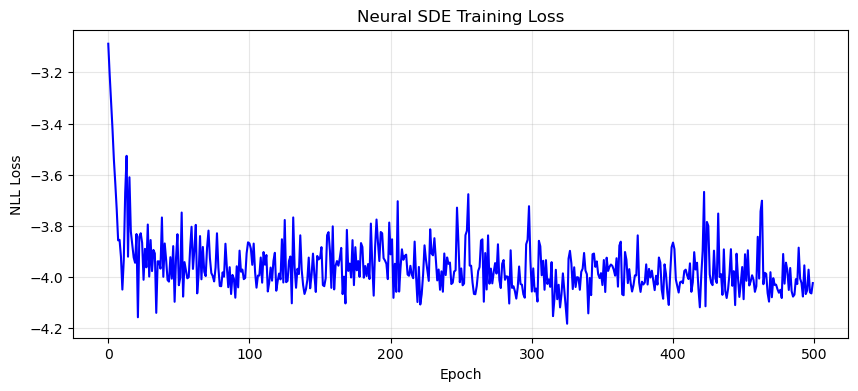

In [17]:
# =============================================================================
# Visualize Training Curve (학습 곡선 시각화)
# =============================================================================

plt.figure(figsize=(10, 4))
plt.plot(loss_history, color='blue')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.title('Neural SDE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Validate Neural SDE (Neural SDE 검증)

Generate paths with trained Neural SDE and compare with real SPY data.
학습된 Neural SDE로 경로를 생성하고, 실제 SPY 데이터와 분포를 비교합니다.

c:\Users\Jun\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


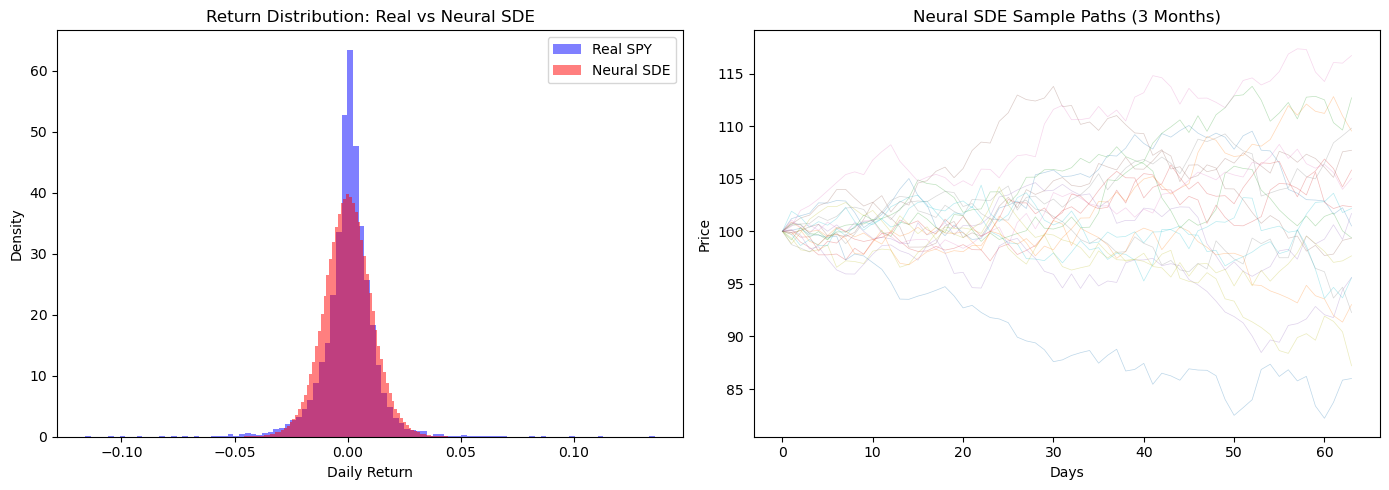


Statistical Comparison (통계 비교):
  Metric                   Real SPY   Neural SDE
  --------------------------------------------
  Mean Return               0.0402%      0.0057%
  Std (Volatility)          1.2010%      1.0644%


In [16]:
# =============================================================================
# Generate Paths and Compare (경로 생성 및 비교)
# =============================================================================

S0 = 100.0
T = 0.25  # 3 months (3개월)
dt = 1.0 / 252
num_paths = 10000

neural_sde.eval()
with torch.no_grad():
    S_neural = neural_sde.simulate(S0, T, dt, num_paths)

S_neural_np = S_neural.cpu().numpy()
neural_returns = np.diff(np.log(S_neural_np), axis=1).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(returns, bins=100, alpha=0.5, label='Real SPY', density=True, color='blue')
axes[0].hist(neural_returns, bins=100, alpha=0.5, label='Neural SDE', density=True, color='red')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title('Return Distribution: Real vs Neural SDE')
axes[0].legend()

for i in range(20):
    axes[1].plot(S_neural_np[i], alpha=0.3, linewidth=0.5)
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price')
axes[1].set_title('Neural SDE Sample Paths (3 Months)')

plt.tight_layout()
plt.show()

print(f"\nStatistical Comparison (통계 비교):")
print(f"  {'Metric':<20} {'Real SPY':>12} {'Neural SDE':>12}")
print(f"  {'-'*44}")
print(f"  {'Mean Return':<20} {returns.mean()*100:>11.4f}% {neural_returns.mean()*100:>11.4f}%")
print(f"  {'Std (Volatility)':<20} {returns.std()*100:>11.4f}% {neural_returns.std()*100:>11.4f}%")

---

# PART 2: Neural Path Integral - DriftNet Integration

## Core Concept (핵심 개념)

We have learned the **"Market Environment"** via Neural SDE.
Now we apply **"Control"** to induce crashes within this environment.
지금까지 Neural SDE로 **"시장 환경"**을 학습했습니다.
이제 그 환경 위에서 **"제어(Control)"**를 가하여 폭락을 유도합니다.

$$dS_t = (\mu_{\theta}(S,t) + \underbrace{u_{\psi}(S,t)}_{\text{Control}}) dt + \sigma_{\phi}(S,t) dW_t$$

Via **Girsanov Theorem**, we can recover the probabilities of the original system even when sampling from the controlled system.
**Girsanov 정리**를 통해 제어된 시스템에서 샘플링하더라도, 원래 시스템의 확률을 복원할 수 있습니다.

In [9]:
# =============================================================================
# Initialize ControlNet (ControlNet 초기화)
# =============================================================================

# Freeze Neural SDE (Environment Fixed) (Neural SDE 고정 - 환경은 변하지 않음)
for param in neural_sde.parameters():
    param.requires_grad = False

# Initialize ControlNet (ControlNet 초기화)
control_net = ControlNet(hidden_dim=64, control_bound=3.0).to(device)
control_optimizer = torch.optim.Adam(control_net.parameters(), lr=1e-3)

# Crash Settings (폭락 설정)
CRASH_THRESHOLD = 0.80  # 20% Drop (20% 하락)
K_crash = CRASH_THRESHOLD * S0

print(f"ControlNet initialized with control_bound=3.0")
print(f"Crash target: S < {K_crash} (20% drop from {S0})")

ControlNet initialized with control_bound=3.0
Crash target: S < 80.0 (20% drop from 100.0)


In [10]:
# =============================================================================
# Training ControlNet for Crash Generation (제어 네트워크 학습)
# =============================================================================

num_iters = 300
batch_size = 5000
T_sim = 0.25  # 3 months (3개월 시뮬레이션)
dt_sim = 0.002

crash_rate_history = []
loss_history_ctrl = []

print("🚀 Training ControlNet for crash generation on Neural SDE...")
print("="*60)

for i in range(num_iters):
    control_optimizer.zero_grad()
    
    # Controlled Simulation (제어된 시뮬레이션)
    S_paths, log_weights = neural_sde.simulate_controlled(
        S0=S0, T=T_sim, dt=dt_sim, num_paths=batch_size, control_net=control_net
    )
    
    S_T = S_paths[:, -1]
    
    # Hinge Loss: Push below target level (목표 가격 아래로 유도)
    margin = 2.0
    target_level = K_crash - margin
    dist_penalty = F.relu(S_T - target_level)
    loss_dist = dist_penalty.mean()
    
    # Regularization: Prevent extreme control (과도한 제어 방지)
    loss_reg = 0.001 * (log_weights ** 2).mean()
    
    loss = loss_dist + loss_reg
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(control_net.parameters(), 1.0)
    control_optimizer.step()
    
    # Record Stats (통계 기록)
    crash_rate = (S_T < K_crash).float().mean().item()
    crash_rate_history.append(crash_rate)
    loss_history_ctrl.append(loss.item())
    
    if i % 50 == 0:
        print(f"Iter {i:3d}: Loss={loss.item():.4f}, Crash Rate={crash_rate*100:.2f}%")

print("="*60)
print(f"✅ Training Complete! Final Crash Rate: {crash_rate_history[-1]*100:.2f}%")

🚀 Training ControlNet for crash generation on Neural SDE...
Iter   0: Loss=5.2153, Crash Rate=42.16%
Iter  50: Loss=0.2148, Crash Rate=98.92%
Iter 100: Loss=0.2068, Crash Rate=99.08%
Iter 150: Loss=0.1987, Crash Rate=99.28%
Iter 200: Loss=0.1885, Crash Rate=99.06%
Iter 250: Loss=0.1779, Crash Rate=98.64%
✅ Training Complete! Final Crash Rate: 99.68%


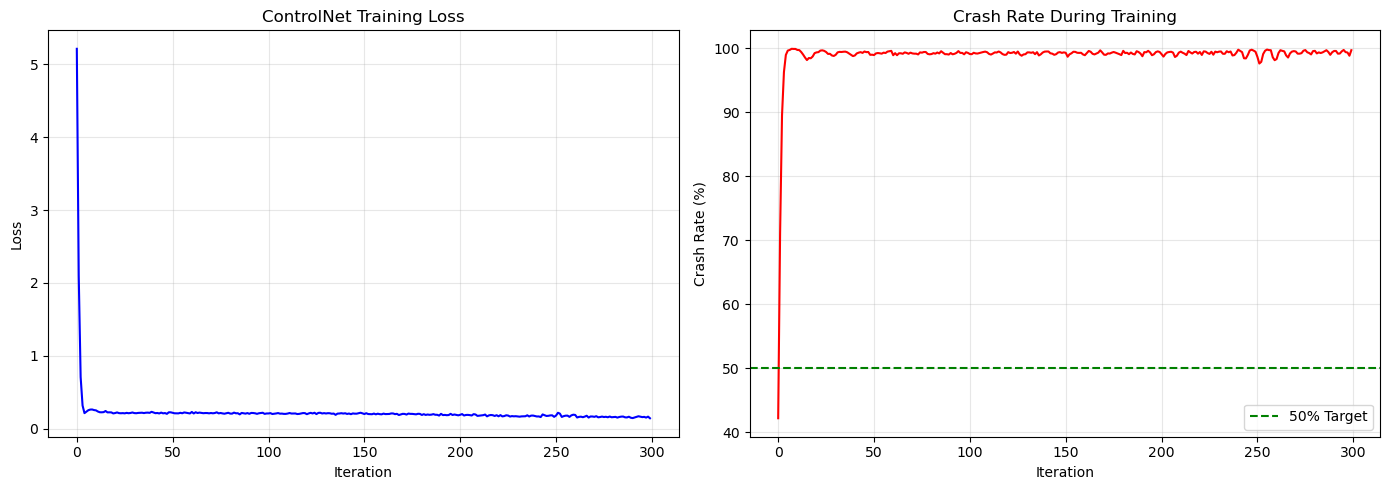

In [15]:
# =============================================================================
# Visualize Training Progress (학습 진행상황 시각화)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(loss_history_ctrl, color='blue')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('ControlNet Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot([r * 100 for r in crash_rate_history], color='red')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Crash Rate (%)')
axes[1].set_title('Crash Rate During Training')
axes[1].axhline(y=50, color='green', linestyle='--', label='50% Target')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Result Comparison: Baseline vs AI-Controlled (결과 비교)

Comparing case without control (Neural SDE Only) vs with control (Neural SDE + ControlNet).
제어가 없는 경우(Neural SDE Only)와 있는 경우(Neural SDE + ControlNet)를 비교합니다.

In [12]:
# =============================================================================
# Final Comparison (최종 비교)
# =============================================================================

num_eval_paths = 20000

# Baseline (No Control) (베이스라인 - 제어 없음)
neural_sde.eval()
with torch.no_grad():
    S_baseline = neural_sde.simulate(S0, T_sim, dt_sim, num_eval_paths)
S_T_baseline = S_baseline[:, -1].cpu().numpy()
baseline_crash_rate = (S_T_baseline < K_crash).mean()

# AI-Controlled (AI 제어 적용)
control_net.eval()
with torch.no_grad():
    S_controlled, log_w = neural_sde.simulate_controlled(
        S0, T_sim, dt_sim, num_eval_paths, control_net
    )
S_T_controlled = S_controlled[:, -1].cpu().numpy()
controlled_crash_rate = (S_T_controlled < K_crash).mean()

# Efficiency Calculation (효율성 계산)
efficiency = controlled_crash_rate / (baseline_crash_rate + 1e-8)

print("\n" + "="*60)
print("   NEURAL PATH INTEGRAL: FINAL RESULTS (최종 결과)")
print("="*60)
print(f"\n[Baseline - Neural SDE Only]")
print(f"  Terminal Price Range: ${S_T_baseline.min():.2f} ~ ${S_T_baseline.max():.2f}")
print(f"  Crash Rate (S < {K_crash}): {baseline_crash_rate*100:.2f}%")

print(f"\n[AI-Controlled - Neural SDE + ControlNet]")
print(f"  Terminal Price Range: ${S_T_controlled.min():.2f} ~ ${S_T_controlled.max():.2f}")
print(f"  Crash Rate (S < {K_crash}): {controlled_crash_rate*100:.2f}%")

print(f"\n[Efficiency Boost (효율성 향상)]")
print(f"  AI is {efficiency:.1f}x more efficient at generating crashes! (AI가 {efficiency:.1f}배 더 효율적)")


   NEURAL PATH INTEGRAL: FINAL RESULTS (최종 결과)

[Baseline - Neural SDE Only]
  Terminal Price Range: $68.29 ~ $132.79
  Crash Rate (S < 80.0): 0.79%

[AI-Controlled - Neural SDE + ControlNet]
  Terminal Price Range: $28.86 ~ $88.22
  Crash Rate (S < 80.0): 99.35%

[Efficiency Boost (효율성 향상)]
  AI is 125.8x more efficient at generating crashes! (AI가 125.8배 더 효율적)


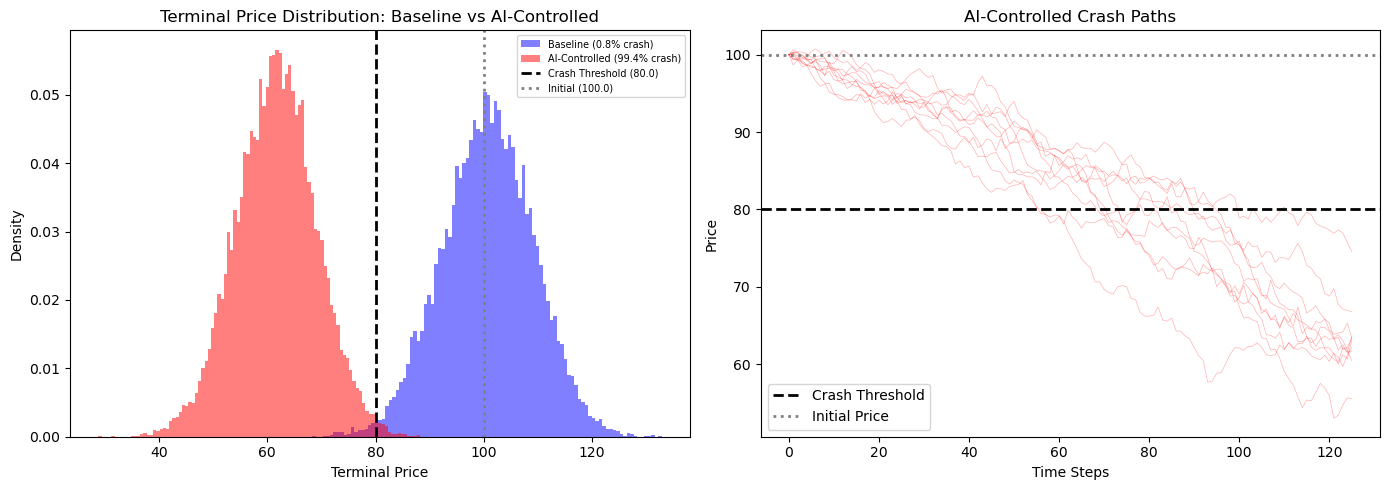

In [26]:
# =============================================================================
# Distribution Comparison Visualization (분포 비교 시각화)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison (히스토그램 비교)
axes[0].hist(S_T_baseline, bins=100, alpha=0.5, label=f'Baseline ({baseline_crash_rate*100:.1f}% crash)', 
             density=True, color='blue')
axes[0].hist(S_T_controlled, bins=100, alpha=0.5, label=f'AI-Controlled ({controlled_crash_rate*100:.1f}% crash)', 
             density=True, color='red')
axes[0].axvline(x=K_crash, color='black', linestyle='--', linewidth=2, label=f'Crash Threshold ({K_crash})')
axes[0].axvline(x=S0, color='gray', linestyle=':', linewidth=2, label=f'Initial ({S0})')
axes[0].set_xlabel('Terminal Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Terminal Price Distribution: Baseline vs AI-Controlled')
axes[0].legend(fontsize='x-small', loc='best', ncol=1)

# Path sample comparison (경로 샘플 비교)
S_ctrl_np = S_controlled.cpu().numpy()
for i in range(10):
    axes[1].plot(S_ctrl_np[i], alpha=0.3, linewidth=0.5, color='red')
axes[1].axhline(y=K_crash, color='black', linestyle='--', linewidth=2, label='Crash Threshold')
axes[1].axhline(y=S0, color='gray', linestyle=':', linewidth=2, label='Initial Price')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Price')
axes[1].set_title('AI-Controlled Crash Paths')
axes[1].legend()

plt.tight_layout()
plt.show()

## Conclusion (결론)

### Completed Neural Path Integral Framework
### 완성된 Neural Path Integral 프레임워크

1. **Neural SDE (Environment)**: Learned market dynamics (Drift, Diffusion) from real S&P 500 data. (실제 S&P 500 데이터로부터 시장 동역학 학습)
2. **ControlNet (Agent)**: Learned control force to induce crashes on the environment. (환경 위에서 폭락을 유도하는 제어력 학습)
3. **Girsanov Weights**: Probabilistic correction to recover original system probabilities. (원래 시스템의 확률을 복원하기 위한 확률적 보정)

### Key Differentiators (차별점)
- Existing Neural SDE: "Generative" (generating realistic data). (기존: 그럴듯한 데이터 생성)
- **Our Approach**: "Rare Event Sampling via Control" (Efficient exploration of extreme events). (우리 방식: 제어를 통한 희귀 사건의 효율적 탐색)
